In [9]:
import os
import time
import glob
import shutil
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

In [10]:
# Problem configuration
start = [0.0, 0.0, 0.0]
goal = [0.0, -5.0, -np.pi/2]
min_dist_to_goal = 0.5

wheel_radius = 0.016 # m
distance_between_wheels = 0.089 # m
max_vel_leftwheel = 100 # rad/s
min_vel_leftwheel = -100 # rad/s
max_vel_rightwheel = 100 # rad/s
min_vel_rightwheel = -100 # rad/s
time_step = 0.01 # s

In [11]:
class TO_MPC():
    def __init__(self, config_file_path=None):
        # Parameters
        self.N = 20
        self.dt = 0.1
        self.nx = 3
        self.nu = 2

        # State limits
        x_min = [-20.0, -20.0, -ca.inf]
        x_max = [20.0, 20.0, ca.inf]

        # Control limits
        u_min = [min_vel_leftwheel, min_vel_rightwheel]
        u_max = [max_vel_leftwheel, max_vel_rightwheel]
        
        # Cost function weights
        Q = ca.diag([100.0, 100.0, 1.0])
        QN = ca.diag([100.0, 100.0, 1.0])
        R = ca.diag([0.0, 0.0])

        # Initial and reference states
        x_init = ca.MX.sym("x_init", self.nx)
        x_ref = ca.MX.sym("x_ref", self.nx)

        # OCP formulation
        X = []
        self.lbX = []
        self.ubX = []
        G = []
        self.lbG = []
        self.ubG = []
        P = []
        J = 0

        for k in range(self.N):
            x = ca.MX.sym(f"x_{k}", self.nx)
            X.append(x)
            self.lbX.extend(x_min)
            self.ubX.extend(x_max)

            G.append(
                x - x_init
                if k == 0
                else x - self.robot_dynamics(x_prev, u_prev, self.dt)  # noqa: F821
            )
            self.lbG.extend(self.nx * [0])
            self.ubG.extend(self.nx * [0])

            u = ca.MX.sym(f"u_{k}", self.nu)
            X.append(u)
            self.lbX.extend(u_min)
            self.ubX.extend(u_max)

            J += (x - x_ref).T @ Q @ (x - x_ref) + u.T @ R @ u

            x_prev = x
            u_prev = u

        x = ca.MX.sym(f"x_{self.N}", self.nx)

        X.append(x)
        self.lbX.extend(x_min)
        self.ubX.extend(x_max)

        G.append(x - self.robot_dynamics(x_prev, u_prev, self.dt))
        self.lbG.extend(self.nx * [0])
        self.ubG.extend(self.nx * [0])

        J += (x - x_ref).T @ QN @ (x - x_ref)

        # NLP parameters
        P.extend([x_init, x_ref])

        # NLP formulation
        nlp = {"f": J, "x": ca.vertcat(*X), "g": ca.vertcat(*G), "p": ca.vertcat(*P)}
        # casadi_tmp_dir = "casadi_tmp/"
        # os.makedirs(casadi_tmp_dir, exist_ok=True)
        opts = {
            "ipopt": {
                "print_level": 4,
                "max_wall_time": self.dt,
                "warm_start_init_point": "yes",
                "hsllib": "/usr/local/lib/libcoinhsl.so",
                "linear_solver": "ma57", # "ma57" or "mumps"
            },
            "jit": True,
            "jit_options": {
                "flags": ["-O3", "-ffast-math"],
                "verbose": True,
                "compiler": "gcc",
                # "directory": casadi_tmp_dir,
                "cleanup": True,
            }
        }

        self.solver = ca.nlpsol("solver", "ipopt", nlp, opts)

        # time.sleep(3)

        # [os.remove(filename) for filename in glob.glob("*.c")]
        # shutil.rmtree(casadi_tmp_dir, ignore_errors=True)

        # Initialize variables
        self.x_opt = np.zeros(len(self.lbX))
        self.lam_x_opt = np.zeros(len(self.lbX))
        self.lam_g_opt = np.zeros(len(self.lbG))

    def robot_dynamics(self, x, u, dt):
        v_left, v_right = u[0], u[1]
        v = wheel_radius * (v_left + v_right) / 2.0
        omega = wheel_radius * (v_right - v_left) / distance_between_wheels

        x_next = ca.vertcat(
            x[0] + v * ca.cos(x[2]) * dt,
            x[1] + v * ca.sin(x[2]) * dt,
            x[2] + omega * dt
        )
        return x_next

    def solve(self, x_init, x_ref):
        P = []
        P.append(x_init)
        P.append(x_ref)
        P = ca.vertcat(*P)

        opt_sol = self.solver(
            x0=self.x_opt,
            lam_x0=self.lam_x_opt,
            lam_g0=self.lam_g_opt,
            lbx=self.lbX,
            ubx=self.ubX,
            lbg=self.lbG,
            ubg=self.ubG,
            p=P,
        )

        self.x_opt = opt_sol["x"].full().flatten()
        self.lam_x_opt = opt_sol["lam_x"]
        self.lam_g_opt = opt_sol["lam_g"]

        u_opt = self.x_opt[self.nx + 0:self.nx + 2]
        return u_opt

In [12]:
to_mpc = TO_MPC()

CasADi - 2025-07-01 22:07:48 MESSAGE("calling "gcc -O3 -ffast-math -fPIC -c jit_tmp2fmDui.c -o ./tmp_casadi_compiler_shellwKgGUM.o"") [.../casadi/solvers/shell_compiler.cpp:229]
CasADi - 2025-07-01 22:07:49 MESSAGE("calling "gcc ./tmp_casadi_compiler_shellwKgGUM.o -o ./tmp_casadi_compiler_shellwKgGUM.so -shared"") [.../casadi/solvers/shell_compiler.cpp:248]


In [13]:
def simulator(x, u, dt=0.01):
    v_left, v_right = u[0], u[1]
    v = wheel_radius * (v_left + v_right) / 2.0
    omega = wheel_radius * (v_right - v_left) / distance_between_wheels

    x_next = np.array(
        [
            x[0] + v * np.cos(x[2]) * dt,
            x[1] + v * np.sin(x[2]) * dt,
            x[2] + omega * dt
        ]
    )
    return x_next

In [22]:
T = 10.0  # Simulation time in seconds
N = int(T / time_step)  # Number of time steps

x_traj = np.zeros((N + 1, 3))
u_traj = np.zeros((N, 2))

x_traj[0] = start

for i in range(N):
    u_opt = to_mpc.solve(x_traj[i], goal)
    u_traj[i] = u_opt
    x_traj[i + 1] = simulator(x_traj[i], u_opt, dt=time_step)

Total number of variables............................:      103
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       82
                     variables with only upper bounds:        0
Total number of equality constraints.................:       63
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:   2.8425667223659497e+04    2.8425667223659497e+04
Dual infeasibility......:   1.4464904026464049e-12    1.4464904026464049e-12
Constraint violation....:   4.4408920985006262e-16    4.4408920985006262e-16
Variable bound violation:   9.9975754608294665e-07    9.9975754608294665e-07
Complementari

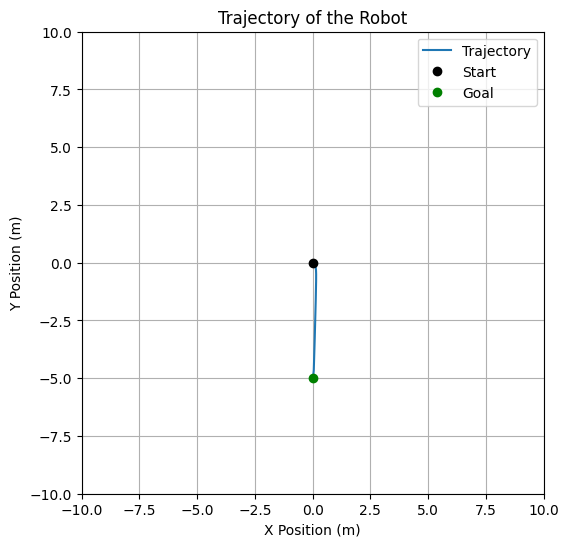

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(x_traj[:, 0], x_traj[:, 1], label='Trajectory')
ax.plot(start[0], start[1], 'ko', label='Start')
ax.plot(goal[0], goal[1], 'go', label='Goal')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_title('Trajectory of the Robot')
ax.set_aspect("equal")
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.legend()
plt.grid()

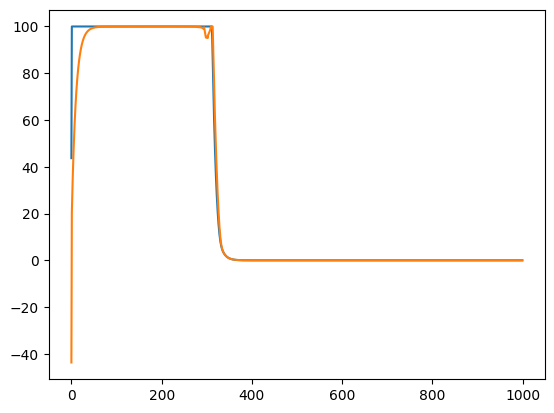

In [24]:
plt.plot(u_traj[:, 0])
plt.plot(u_traj[:, 1])